/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]
Extracting Features: 100%|██████████| 375/375 [54:13<00:00,  8.68s/it]



🔹 Training SVM (RBF Kernel)...

📊 Classification Report for SVM (RBF Kernel):
              precision    recall  f1-score   support

 Agriculture       0.96      0.97      0.97       160
     Airport       0.85      0.85      0.85       160
       Beach       0.90      0.95      0.92       160
        City       0.92      0.89      0.91       160
      Desert       0.95      0.96      0.96       160
      Forest       0.97      0.93      0.95       160
   Grassland       0.91      0.91      0.91       160
     Highway       0.96      0.95      0.95       160
        Lake       0.89      0.85      0.87       160
    Mountain       0.95      0.96      0.95       160
     Parking       0.95      0.96      0.96       160
        Port       0.93      0.94      0.93       160
     Railway       0.89      0.91      0.90       160
 Residential       0.98      0.99      0.99       160
       River       0.87      0.85      0.86       160

    accuracy                           0.93      2400
 

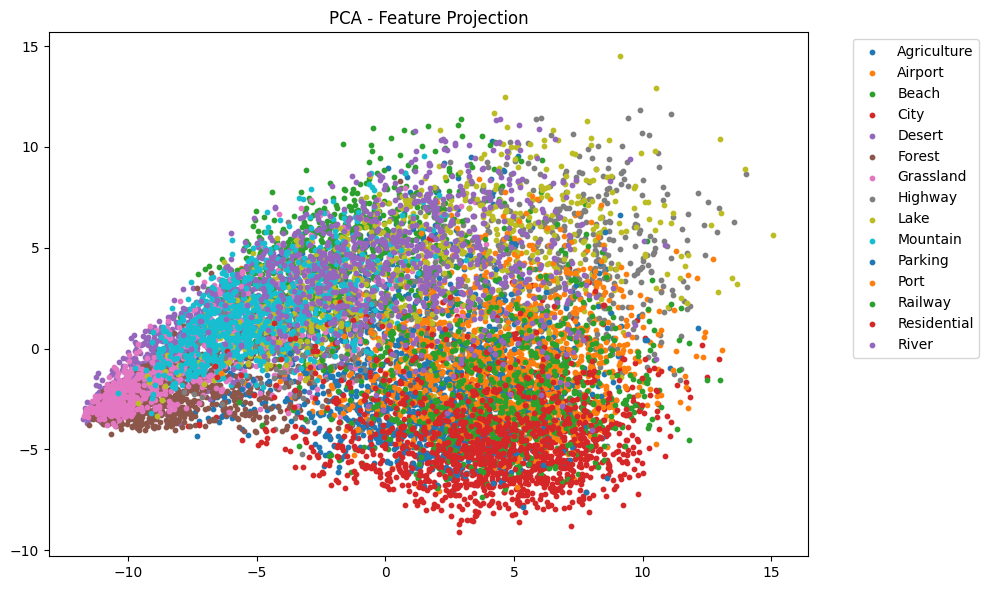


🎨 Visualising with t-SNE...


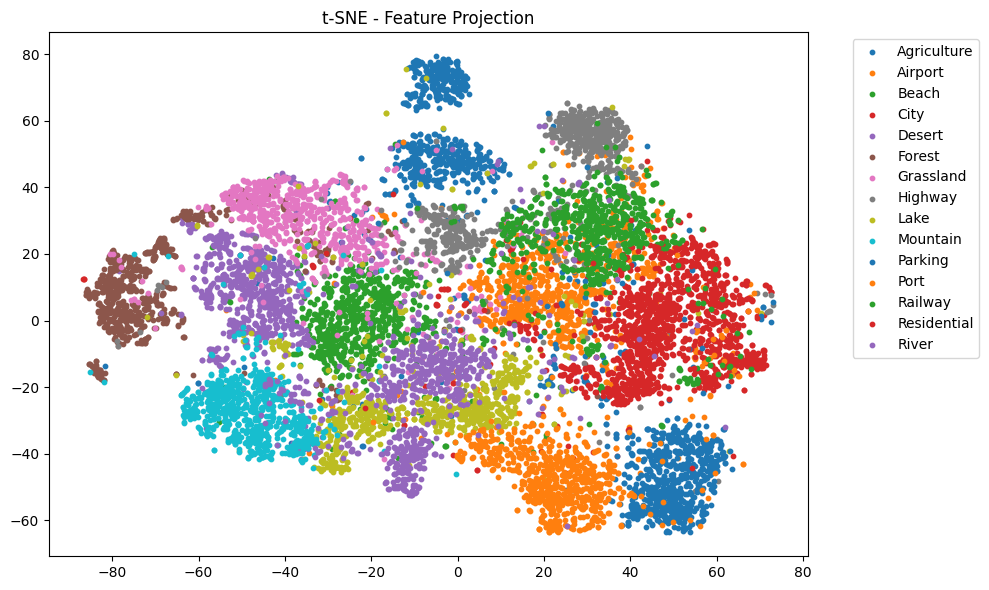

In [1]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import kagglehub

# Setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224
BATCH_SIZE = 32

# Load Dataset
path = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")
DATA_DIR = os.path.join(path, "Aerial_Landscapes")

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
class_names = dataset.classes
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load pretrained ResNet50 (feature extractor)
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))
resnet.eval().to(DEVICE)

# Extract Features
def extract_features(loader):
    features, labels = [], []
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Extracting Features"):
            inputs = inputs.to(DEVICE)
            outputs = resnet(inputs).squeeze()  # shape: [batch, 2048]
            features.append(outputs.cpu().numpy())
            labels.extend(targets.numpy())
    return np.vstack(features), np.array(labels)

X, y = extract_features(loader)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Classifiers
models_dict = {
    "SVM (RBF Kernel)": make_pipeline(StandardScaler(), SVC(kernel='rbf', C=10)),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
}

# Train & Evaluate
for name, clf in models_dict.items():
    print(f"\n🔹 Training {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

# Visualize Features with PCA and t-SNE
def plot_features(X, y, method="PCA"):
    if method == "PCA":
        reducer = PCA(n_components=2)
        title = "PCA - Feature Projection"
    else:
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        title = "t-SNE - Feature Projection"

    reduced = reducer.fit_transform(X)
    plt.figure(figsize=(10, 6))
    for i in np.unique(y):
        plt.scatter(reduced[y == i, 0], reduced[y == i, 1], label=class_names[i], s=10)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

print("\n🎨 Visualising with PCA...")
plot_features(X, y, method="PCA")

print("\n🎨 Visualising with t-SNE...")
plot_features(X, y, method="t-SNE")